In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import f_oneway
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Load data
df = pd.read_csv("spikes_full.csv")

In [3]:
# Filter out missing values
df = df[df["Baselined FR"].notnull()]
df = df[df["Identity"].notnull()]

In [4]:
identity_neurons_by_subject = {}

In [5]:
for subject in df["Subject ID"].unique():
    df_subject = df[df["Subject ID"] == subject]
    subject_neuron_ids = df_subject["Neuron ID"].unique()
    identity_neurons_by_subject[subject] = []

    for neuron_id in subject_neuron_ids:
        df_neuron = df_subject[df_subject["Neuron ID"] == neuron_id]

        identities = df_neuron["Identity"].unique()
        fr_by_identity = [
            df_neuron[df_neuron["Identity"] == i]["Baselined FR"].values for i in identities
        ]

        # Skip if any identity has <2 trials
        if any(len(x) < 2 for x in fr_by_identity):
            continue

        # One-way ANOVA
        f_stat, p_val = f_oneway(*fr_by_identity)

        if p_val < 0.05:
            identity_means = np.array([np.mean(x) for x in fr_by_identity])
            overall_mean = np.mean(identity_means)
            overall_std = np.std(identity_means)

            if np.any(identity_means > overall_mean + 2 * overall_std):
                identity_neurons_by_subject[subject].append(neuron_id)

/home/nuttidalab/anaconda3/envs/cog_flex/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


In [6]:
# Build a DataFrame from your identity neuron dictionary
rows = []
for subject, neurons in identity_neurons_by_subject.items():
    for neuron in neurons:
        rows.append({"Subject ID": subject, "Neuron ID": neuron})

df_identity_neurons = pd.DataFrame(rows)

In [7]:
# Add brain area info
df_info = df[["Neuron ID", "Neuron Area"]].drop_duplicates()
df_identity_neurons = df_identity_neurons.merge(df_info, on="Neuron ID", how="left")

# Classify region
df_identity_neurons["Region"] = df_identity_neurons["Neuron Area"].apply(
    lambda x: "Hippocampus" if str(x).endswith("H") else "Amygdala"
)

region_counts = df_identity_neurons.groupby(["Subject ID", "Region"])["Neuron ID"].nunique().unstack(fill_value=0)

# Ensure consistent order
region_counts = region_counts.sort_index()

In [8]:
total_identity_neurons = df_identity_neurons["Neuron ID"].nunique()
print(f"Total identity-selective neurons: {total_identity_neurons}")

Total identity-selective neurons: 199


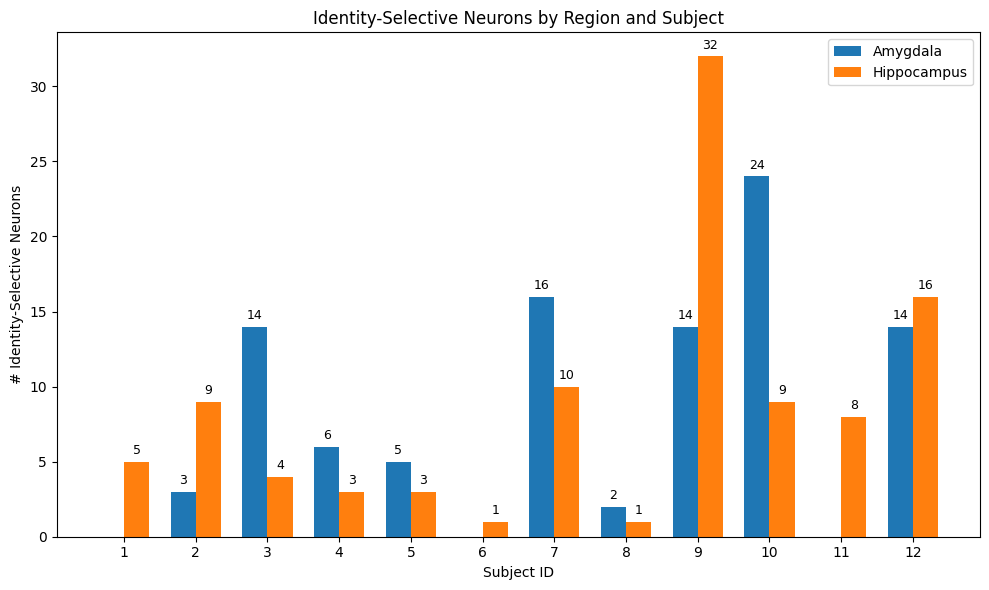

In [ ]:
region_counts = region_counts.sort_index()
subjects = region_counts.index.astype(str)
amygdala_counts = region_counts["Amygdala"]
hippocampus_counts = region_counts["Hippocampus"]

x = np.arange(len(subjects))
width = 0.35

plt.figure(figsize=(10, 6))

# Plot bars
bars_amygdala = plt.bar(x - width/2, amygdala_counts, width, label="Amygdala")
bars_hippocampus = plt.bar(x + width/2, hippocampus_counts, width, label="Hippocampus")

# Add labels above Amygdala bars
for bar in bars_amygdala:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.3, str(int(height)),
                 ha='center', va='bottom', fontsize=9)

# Add labels above Hippocampus bars
for bar in bars_hippocampus:
    height = bar.get_height()
    if height > 0:
        plt.text(bar.get_x() + bar.get_width()/2, height + 0.3, str(int(height)),
                 ha='center', va='bottom', fontsize=9)

# Final formatting
plt.xlabel("Subject ID")
plt.ylabel("# Identity-Selective Neurons")
plt.title("Identity-Selective Neurons by Region and Subject")
plt.xticks(x, subjects)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
# Load and filter data
df = pd.read_csv("spikes_full.csv")
df = df[df["Baselined FR"].notnull()]
df = df[df["Identity"].notnull()]

# Store results in a list of dicts
identity_neurons = []

In [11]:
for neuron in df["Neuron ID"].unique():
    d = df[df["Neuron ID"] == neuron]
    groups = [d[d["Identity"] == i]["Baselined FR"].values for i in d["Identity"].unique()]
    
    if any(len(g) < 2 for g in groups):
        continue

    stat, p = f_oneway(*groups)
    if p < 0.05:
        means = np.array([np.mean(g) for g in groups])
        overall_mean = np.mean(means)
        overall_std = np.std(means)
        selective = means > overall_mean + 2 * overall_std
        num_selective = np.sum(selective)

        if num_selective >= 1:
            identity_neurons.append({
                "Neuron ID": neuron,
                "Num Selective Identities": int(num_selective)
            })

/home/nuttidalab/anaconda3/envs/cog_flex/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: ConstantInputWarning: Each of the input arrays is constant; the F statistic is not defined or infinite
  res = hypotest_fun_out(*samples, **kwds)


In [12]:
# Convert to DataFrame
df_identity_neurons = pd.DataFrame(identity_neurons)

In [13]:
# Merge back to get brain areas
df_info = df[["Neuron ID", "Neuron Area"]].drop_duplicates()
df_identity_neurons = df_identity_neurons.merge(df_info, on="Neuron ID", how="left")

In [14]:
# Classify brain region
df_identity_neurons["Region"] = df_identity_neurons["Neuron Area"].apply(
    lambda x: "Hippocampus" if str(x).endswith("H") else "Amygdala"
)

In [15]:
# Count neurons per region
region_counts = df_identity_neurons.groupby("Region")["Neuron ID"].nunique()

In [16]:
# Count single vs multi-selective
single = (df_identity_neurons["Num Selective Identities"] == 1).sum()
multi = (df_identity_neurons["Num Selective Identities"] > 1).sum()

In [17]:
print("Identity Selectivity Summary")
print(f"   • Neurons selective for only 1 identity: {single}")
print(f"   • Neurons selective for multiple identities: {multi}")

Identity Selectivity Summary
   • Neurons selective for only 1 identity: 57
   • Neurons selective for multiple identities: 142


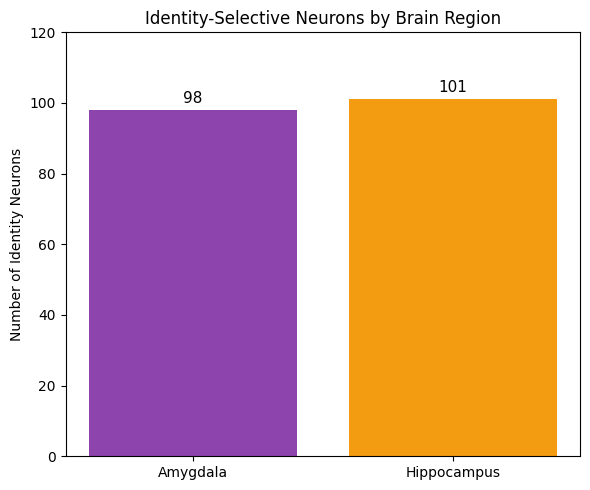

In [18]:
# Plot by brain region
plt.figure(figsize=(6, 5))
bars = plt.bar(region_counts.index, region_counts.values, color=["#8e44ad", "#f39c12"])
for i, val in enumerate(region_counts.values):
    plt.text(i, val + 2, str(val), ha='center', fontsize=11)

plt.ylim(0, 120)
plt.ylabel("Number of Identity Neurons")
plt.title("Identity-Selective Neurons by Brain Region")
plt.tight_layout()
plt.show()